## Galaxy contour plot

### Import packages

In [53]:
## testing multidark
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import h5py
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import pickle
import os
from glob import glob
import scipy

In [54]:
datadir = '/pscratch/sd/z/zzhang13/SDSS/'

### Import redMaPPer and member catalog

* redmapper_dr8_public_v6.3_catalog.fits
* redmapper_dr8_public_v6.3_members.fits

In [55]:
#Only record array pickle file
import pickle
from astropy.table import Table


RM_file = datadir + 'redmapper_dr8_public_v6.3_catalog.fits'
RM_data = Table.read(RM_file)

##Filtering out multi-valued columns
names = [name for name in RM_data.dtype.names if len(RM_data[name].shape) <= 1]
#RM_data = RM_data[names]
RM_df = RM_data[names].to_pandas()
RM_df.columns

Index(['ID', 'NAME', 'RA', 'DEC', 'Z_LAMBDA', 'Z_LAMBDA_ERR', 'LAMBDA',
       'LAMBDA_ERR', 'S', 'Z_SPEC', 'OBJID', 'IMAG', 'IMAG_ERR', 'MODEL_MAG_U',
       'MODEL_MAGERR_U', 'MODEL_MAG_G', 'MODEL_MAGERR_G', 'MODEL_MAG_R',
       'MODEL_MAGERR_R', 'MODEL_MAG_I', 'MODEL_MAGERR_I', 'MODEL_MAG_Z',
       'MODEL_MAGERR_Z', 'ILUM'],
      dtype='object')

### Galaxy catalog

In [56]:
#Only record array pickle file
RM_mem_file = datadir + 'redmapper_dr8_public_v6.3_members.fits'
RM_mem_data = Table.read(RM_mem_file)

##Filtering out multi-valued columns
names = [name for name in RM_mem_data.dtype.names if len(RM_mem_data[name].shape) <= 1]
#RM_data = RM_data[names]
RM_mem_df = RM_mem_data[names].to_pandas()
RM_mem_df.head()

,ID,RA,DEC,R,P,P_FREE,THETA_I,THETA_R,IMAG,IMAG_ERR,...,MODEL_MAG_G,MODEL_MAGERR_G,MODEL_MAG_R,MODEL_MAGERR_R,MODEL_MAG_I,MODEL_MAGERR_I,MODEL_MAG_Z,MODEL_MAGERR_Z,Z_SPEC,OBJID
0,1,239.852334,27.216850,1.079695,0.907741,1.0,1.0,0.739267,0.0,0.0,...,17.096111,0.004797,16.144676,0.003606,15.706505,0.003757,15.367328,0.007595,0.092960,1237662664290402765
1,1,239.752627,27.095086,0.920870,0.804422,1.0,1.0,0.999933,0.0,0.0,...,18.370716,0.009488,17.353680,0.006270,16.914942,0.006140,16.525486,0.012563,0.089536,1237662305662992496
2,1,239.811968,27.172997,0.955226,0.959019,1.0,1.0,0.999127,0.0,0.0,...,18.266935,0.009735,17.324764,0.006860,16.920277,0.007729,16.574057,0.019480,0.090863,1237662664290402755
3,1,239.801773,27.099718,1.062198,0.864776,1.0,1.0,0.839163,0.0,0.0,...,16.761656,0.004821,15.825936,0.003578,15.402042,0.003866,15.038588,0.008395,0.086508,1237662664290402821
4,1,239.839223,27.196538,1.038076,0.915557,1.0,1.0,0.929687,0.0,0.0,...,17.334044,0.005562,16.386499,0.004084,15.944184,0.004318,15.608700,0.009374,0.091500,1237662664290402773


### Import the matched BGS catalog if available.

In [57]:
with open('bgs_clus_RM_gal_matched.pickle', 'rb') as handle:
    bgs_matched = pickle.load(handle)

## Merging the galaxy and RM files

In [58]:
merge_df = pd.merge(RM_df, RM_mem_df, on="ID", how="inner") 
merge_df.head()

,ID,NAME,RA_x,DEC_x,Z_LAMBDA,Z_LAMBDA_ERR,LAMBDA,LAMBDA_ERR,S,Z_SPEC_x,...,MODEL_MAG_G_y,MODEL_MAGERR_G_y,MODEL_MAG_R_y,MODEL_MAGERR_R_y,MODEL_MAG_I_y,MODEL_MAGERR_I_y,MODEL_MAG_Z_y,MODEL_MAGERR_Z_y,Z_SPEC_y,OBJID_y
0,1,b'RMJ155820.0+271400.3',239.583329,27.233413,0.094831,0.004582,169.837845,4.187026,1.011366,0.090807,...,17.096111,0.004797,16.144676,0.003606,15.706505,0.003757,15.367328,0.007595,0.092960,1237662664290402765
1,1,b'RMJ155820.0+271400.3',239.583329,27.233413,0.094831,0.004582,169.837845,4.187026,1.011366,0.090807,...,18.370716,0.009488,17.353680,0.006270,16.914942,0.006140,16.525486,0.012563,0.089536,1237662305662992496
2,1,b'RMJ155820.0+271400.3',239.583329,27.233413,0.094831,0.004582,169.837845,4.187026,1.011366,0.090807,...,18.266935,0.009735,17.324764,0.006860,16.920277,0.007729,16.574057,0.019480,0.090863,1237662664290402755
3,1,b'RMJ155820.0+271400.3',239.583329,27.233413,0.094831,0.004582,169.837845,4.187026,1.011366,0.090807,...,16.761656,0.004821,15.825936,0.003578,15.402042,0.003866,15.038588,0.008395,0.086508,1237662664290402821
4,1,b'RMJ155820.0+271400.3',239.583329,27.233413,0.094831,0.004582,169.837845,4.187026,1.011366,0.090807,...,17.334044,0.005562,16.386499,0.004084,15.944184,0.004318,15.608700,0.009374,0.091500,1237662664290402773


### Add and modify properties of the merged catalog

In [59]:
R_lambda = (merge_df.LAMBDA/100)**0.2
merge_df['R_LAMBDA'] = R_lambda

In [60]:
cut = np.where(merge_df['Z_SPEC_y'] != merge_df['Z_SPEC_x'])[0]
merge_df = merge_df.iloc[cut]
merge_df = merge_df.iloc[np.where(merge_df['Z_SPEC_x'] > 0)]

## Plotting the distribution of galaxies around center.

In [61]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.cosmology.units as cu
from astropy.cosmology import Planck18

In [62]:
def spherical_to_cartesian(ra, dec):
    """
    Calculate cartesian coordinates on a unit sphere given two angular coordinates.
    parameters

    Parameters
    -----------
    ra : array
        Angular coordinate in degrees

    dec : array
        Angular coordinate in degrees

    Returns
    --------
    x,y,z : sequence of arrays
        Cartesian coordinates.

    Examples
    ---------
    >>> ra, dec = 0.1, 1.5
    >>> x, y, z = spherical_to_cartesian(ra, dec)

    """

    rar = np.radians(ra)
    decr = np.radians(dec)

    x = np.cos(rar) * np.cos(decr)
    y = np.sin(rar) * np.cos(decr)
    z = np.sin(decr)

    return x, y, z

In [63]:
def haversine(lon1, lat1, lon2, lat2, r=1):
    """
    Calculate the great circle distance in kilometers between two points (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    return c*r

### Describe the radius of members within clusters

In [64]:
grouped_df = merge_df.groupby(by='ID')
r_group = []

for name, group in grouped_df:
    
    rm_z = group['Z_SPEC_x'].values * cu.redshift
    rm_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))

    #Compute distances
    r = haversine(group['RA_y'], group['DEC_y'], group['RA_x'], \
                  group['DEC_x'], r=rm_d)
    r_group = np.hstack((r_group, r))

### Radius within 2D aperture including projection effects

In [65]:
smallz = merge_df.iloc[np.where(np.abs(merge_df['Z_SPEC_y']-merge_df['Z_SPEC_x'])/(1+merge_df['Z_SPEC_y']) < 0.1)[0]]
rm_z = smallz['Z_SPEC_x'].values * cu.redshift
rm_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))


#Compute distances
r_2daper = haversine(smallz['RA_y'], smallz['DEC_y'], smallz['RA_x'], \
              smallz['DEC_x'], r=rm_d)

### Distribution of RM centers?

In [66]:
rm_df = merge_df.loc[merge_df['ID'].drop_duplicates().index]
rm_z = rm_df['Z_SPEC_x'].values * cu.redshift
#rm_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving")).value
rm_d =  (0.2* cu.redshift).to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving")).value

In [67]:
from scipy.spatial import KDTree, distance_matrix
#Compute distances
rm_pos = np.array(spherical_to_cartesian(rm_df['RA_x'], rm_df['DEC_x'])).T * rm_d#[:,np.newaxis]
#rm_df['pos'] *= np.ones_like(rm_df['pos'])]

#Constructing KDTree for pair counting
rtree = KDTree(rm_pos)

#Number of random points
#sdm = rtree.sparse_distance_matrix(rtree, p=2, max_distance = 5, output_type='ndarray')

dm = distance_matrix(rm_pos, rm_pos, p=2, threshold=1000000)
dm_flat = np.reshape(dm, -1)
dm_flat = dm_flat[np.where(dm_flat > 0)] ## Remove the diagonal terms. Those are distances to itself. 

### Distribution of BGS catalogs

In [68]:
smallz = bgs_matched[np.where(np.abs(bgs_matched['Z_BGS']-bgs_matched['Z_SPEC_x'])/(1+bgs_matched['Z_BGS']) < 0.1)]
rm_z = smallz['Z_SPEC_x'] * cu.redshift
rm_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))

r_bgs = haversine(smallz['RA_BGS'], smallz['DEC_BGS'], smallz['RA_x'], \
              smallz['DEC_x'], r=rm_d)

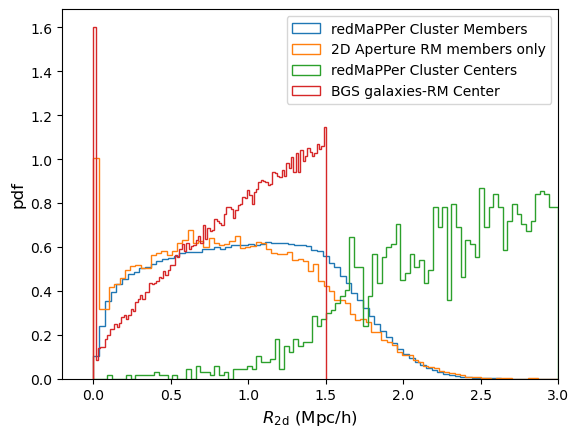

In [72]:
plt.hist(r_group, histtype='step', bins=100, label='redMaPPer Cluster Members', density=True)
plt.hist(r_2daper, histtype='step', bins=100, label = '2D Aperture RM members only', density=True)
plt.hist(dm_flat, bins=100, range=(0,3), histtype='step', label='redMaPPer Cluster Centers', density=True)
plt.hist(r_bgs, bins=100, histtype='step', label='BGS galaxies-RM Center', density=True)
plt.ylabel(r'pdf', fontsize=12)
plt.xlabel(r'$R_{\rm 2d}$ (Mpc/h)', fontsize=12)
plt.legend()
plt.xlim((-0.2,3))
plt.show()

## Plotting 2D distribution
* $z \in [0,0.2)$
* $z \in [0.2, 0.4)$
* $z \in [0.4, 0.6)$ 

In [52]:
z_bins = [[0,0.2],[0.2,0.4],[0.4,0.6],[0,1]]

In [87]:
for i, z_bin in enumerate(z_bins):
    print(i)
    print(z_bin)

0
[0, 0.2]
1
[0.2, 0.4]
2
[0.4, 0.6]
3
[0, 1]


AttributeError: 'tuple' object has no attribute 'cmap'

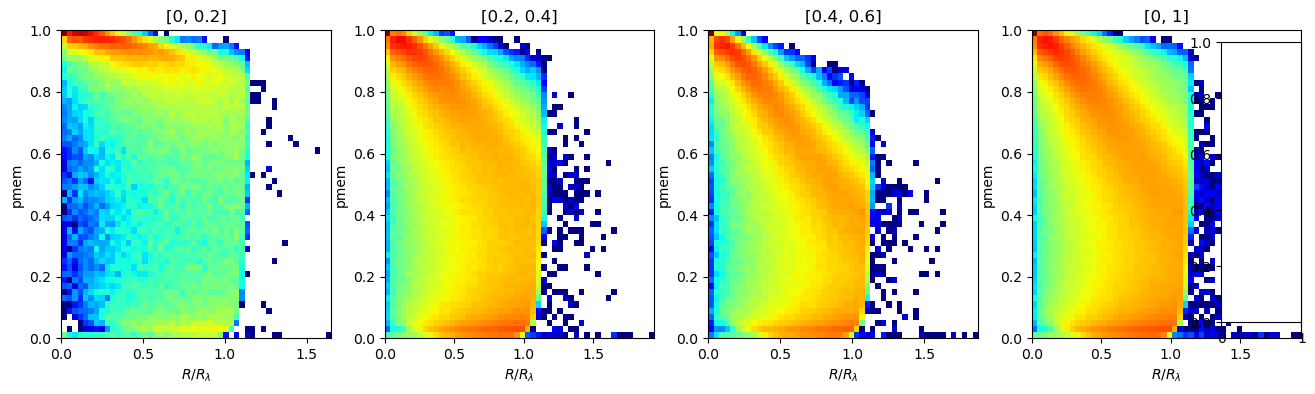

In [95]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,len(z_bins), figsize=(16,4))


for i, z_bin in enumerate(z_bins):
    z_min = z_bin[0]; z_max = z_bin[1]
    mask = (merge_df.Z_LAMBDA >= z_min) & (merge_df.Z_LAMBDA < z_max)
    cur_df = merge_df[mask]
    pcm = axs[i].hist2d(cur_df.R/cur_df.R_LAMBDA, cur_df.P, bins=(50, 50), cmap=plt.cm.jet, norm=LogNorm())
    axs[i].set_title(z_bin)
    axs[i].set_ylabel('pmem')
    axs[i].set_xlabel(r'$R/R_{\lambda}$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pcm, cax=cbar_ax)
plt.show()

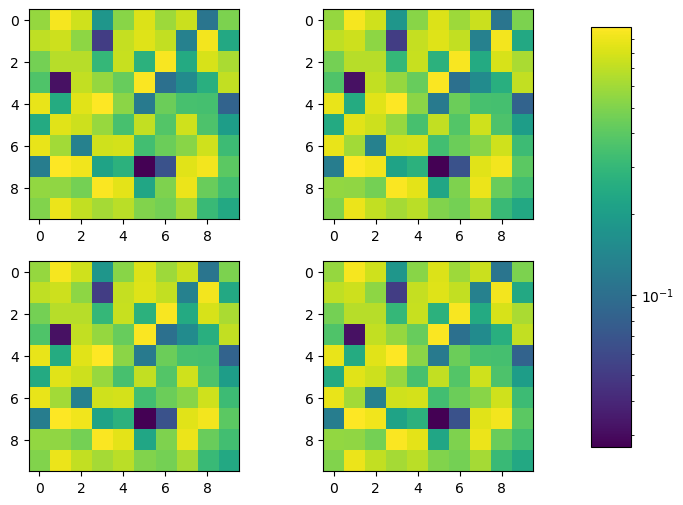

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

data = np.random.rand(10, 10)
for ax in axes.flat:
    im = ax.imshow(data, cmap='viridis',norm=LogNorm())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [14]:
import pickle

with open('RM_SDSS_df.pkl', 'wb') as handle:
    pickle.dump(merge_df, handle, protocol=pickle.HIGHEST_PROTOCOL)